# Bufferbloat Analysis
*Submitted by - Kshitij Shrivastava*

*Course : Advanced Computer Network*


In [34]:
from mininet.topo import Topo

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()
        
        # Create switch s0 (the router)
        router = self.addSwitch('s0')
        
        # Create two hosts with names 'h1' and 'h2'
        h1 = self.addHost('h1')
        h2 = self.addHost('h2')

        # Add links with appropriate bandwidth, delay, and queue size parameters.
        self.addLink(h1, router, bw=1000, delay='10ms', max_queue_size=queue_size)
        self.addLink(h2, router, bw=1.5, delay='10ms', max_queue_size=queue_size)

        return

Next, we need a couple of helper functions to generate traffic between the two hosts. The following function starts a long-lived TCP flow which sends data from h1 to h2 using **iperf**. [Iperf](https://iperf.fr/) is "a tool for active measurements of the maximum achievable bandwidth on IP networks."  You can think of this iperf traffic like a one-way video call. It continually attempts to send a high volume of traffic from the web server h1 to the home computer h2. 

The following function receives one argument called `net`, which is an instance of mininet with a BBTopo topology that we have created above. We have written the part for the iperf server (h2). Notice that in iperf, server is the one that receives data, which should be the home computer h2. You need to complete the function to also start iperf on the iperf client (h1). The iperf session should run for the number of seconds given in the `experiment_time` argument.

You will need to use the `popen` function to run shell commands on a mininet host. The first argument to `popen` is a string command just like you would run in your shell. The second argument should be `shell=True`. You will need to look up the appropriate command line options to run iperf as a client for a given amount of time in the documentation here: [https://iperf.fr/iperf-doc.php#3doc](https://iperf.fr/iperf-doc.php#3doc). You will also need to include the IP address of h2 in your iperf command. This IP address can be accessed with the `h2.IP()` method.  

In [35]:
def start_iperf(net, experiment_time):
    # Start a TCP server on host 'h2' using perf. 
    # The -s parameter specifies server mode
    # The -w 16m parameter ensures that the TCP flow is not receiver window limited (not necessary for client)
    print "Starting iperf server"
    h2 = net.get('h2')
    server = h2.popen("iperf -s -w 16m", shell=True)
    
    # TODO: Start an TCP client on host 'h1' using iperf. 
    #       Ensure that the client runs for experiment_time seconds
    print "Starting iperf client"
    h1 = net.get('h1')
    h1.popen("iperf -c {} -t {}".format(h2.IP(), experiment_time), shell=True)
    #TODO DONE

Next, you need to complete the following function that starts a back-to-back ping train from h1 to h2 to measure RTTs. A ping should be sent every 0.1 seconds. Results should be redirected from stdout to the `outfile` argument.

As before, `net` is an instance of mininet with a BBTopo topology. As before, you will need to use `popen`.  The command argument to `popen` can redirect stdout using `>` just like a normal shell command.  Read the man page for `ping` for details on available command line arguments. Make sure the second argument to `popen` is `shell=True`.

In [36]:
def start_ping(net, outfile="pings.txt"):
    # TODO: Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile

    # Retrieve hosts from the Mininet network
    
    h1 = net.get('h1')
    h2 = net.get('h2')
    # Start a ping train from h1 to h2 with 0.1 seconds between pings    
    print "Starting ping train"
    h1.popen("ping -i 0.1 {} > {}".format(h2.IP(), outfile), shell=True)
    #TODO DONE

Next, we develop some helper functions to measure the congestion window of the TCP traffic. This will let us analyze at the dynamics of the TCP connections in the mininet network. The following functions are already complete.

In [37]:
from subprocess import Popen
import os

def start_tcpprobe(outfile="cwnd.txt"):
    print("Starting TCP probe. Output: {}".format(outfile))
    os.system("sudo rmmod tcp_probe; sudo modprobe tcp_probe")
    process = Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)
def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()

We then create a helper function that monitors the queue length on a given interface. This will let us analyze how the number of packets in router buffer queues affects performance. This function is already complete.

In [38]:
from multiprocessing import Process
from monitor import monitor_qlen

def start_qmon(iface, interval_sec=0.1, outfile="q.txt"):
    monitor = Process(target=monitor_qlen,
                      args=(iface, interval_sec, outfile))
    monitor.start()
    return monitor

We also need a helper function that starts a webserver on h1. This function is already complete.

In [39]:
from time import sleep

def start_webserver(net):
    h1 = net.get('h1')
    proc = h1.popen("python http/webserver.py", shell=True)
    sleep(1)
    return [proc]

Finally, we need a helper function that runs on h2, fetches the website from h1 every 3 seconds for `experiment_time`, and prints the average and standard deviation of the download times. This function is already complete

In [40]:
from time import time
from numpy import mean, std
from time import sleep

def fetch_webserver(net, experiment_time):
    h2 = net.get('h2')
    h1 = net.get('h1')
    download_times = []
    
    start_time = time()
    while True:
        sleep(3)
        now = time()
        if now - start_time > experiment_time:
            break
        fetch = h2.popen("curl -o /dev/null -s -w %{time_total} ", h1.IP(), shell=True)
        download_time, _ = fetch.communicate()
        print "Download time: {0}, {1:.1f}s left...".format(download_time, experiment_time - (now-start_time))
        download_times.append(float(download_time))
        
    average_time = mean(download_times)
    std_time = std(download_times)
    print "\nDownload Times: {}s average, {}s stddev\n".format(average_time, std_time)

Now, we need to put together all the pieces to create the network, start all the traffic, and make the measurements. 

The following `bufferbloat()` function should:
* create a `BBTopo` object
* start the TCP and queue monitors
* start a long-lived TCP flow using iperf
* start the ping train
* start the webserver
* Periodically download the index.html web page from h1 and measure how long it takes to fetch it 

Note that the long lived flow, ping train, and webserver downloads should all be happening simultaneously. Once you have completed the assignment steps up until here, complete the sections marked `TODO` in the below `bufferbloat()` function. Each TODO section requires adding one line to call a function defined above.

In [41]:
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

from time import time
import os
from subprocess import call

def bufferbloat(queue_size, experiment_time, experiment_name):
    # Don't forget to use the arguments!
    
    # Set the cwnd control algorithm to "reno" (half cwnd on 3 duplicate acks)
    #    Modern Linux uses CUBIC-TCP by default that doesn't have the usual sawtooth
    #    behaviour.  For those who are curious, replace reno with cubic
    #    see what happens...
    os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")
    
    # create the topology and network
    topo = BBTopo(queue_size)
    net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink, 
                  controller= OVSController)
    net.start()

    # Print the network topology 
    dumpNodeConnections(net.hosts)
    
    # Performs a basic all pairs ping test to ensure the network set up properly
    net.pingAll()
    
    # Start monitoring TCP cwnd size
    outfile = "{}_cwnd.txt".format(experiment_name)
    start_tcpprobe(outfile)

    # TODO: Start monitoring the queue sizes with the start_qmon() function.
    #       Fill in the iface argument with "s0-eth2" if the link from s0 to h2
    #       is added second in BBTopo or "s0-eth1" if the link from s0 to h2
    #       is added first in BBTopo. This is because we want to measure the 
    #       number of packets in the outgoing queue from s0 to h2. 
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface="s0-eth2", outfile=outfile)#written

    # TODO: Start the long lived TCP connections with the start_iperf() function
    start_iperf(net, experiment_time)
    
    # TODO: Start pings with the start_ping() function
    outfile = "{}_pings.txt".format(experiment_name)
    start_ping(net, outfile=outfile)
    
    # TODO: Start the webserver with the start_webserver() function
    start_webserver(net)
    
    # TODO: Measure and print website download times with the fetch_webserver() function
    fetch_webserver(net, experiment_time)
    
    # Stop probing 
    stop_tcpprobe()
    qmon.terminate()
    net.stop()
    
    # Ensure that all processes you create within Mininet are killed.
    Popen("pgrep -f webserver.py | xargs kill -9", shell=True).wait()
    call(["mn", "-c"])

Once you have completed all the steps above, use the `bufferbloat()` function to run the experiment twice, once with queue size of a 20 packets and then queue size of 100 packets. Make sure to run the experiments long enough to see the dynamics of TCP, like the sawtooth behavior of cwnd, in your results (300 seconds should be good).  Choose `experiment_name` arguments that reflect the queue size

In [42]:
from subprocess import call
call(["mn", "-c"])

# TODO: call the bufferbloat function twice, once with queue size of 20 packets and once with a queue size of 100.

# bufferbloat experiment with queue size 20 packets
bufferbloat(queue_size=20, experiment_time=300, experiment_name="queue20")

# bufferbloat experiment with queue size 100 packets
bufferbloat(queue_size=100, experiment_time=300, experiment_name="queue100")


h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting TCP probe. Output: queue20_cwnd.txt
Starting iperf server
Starting iperf client
Starting ping train
Download time: 0.540, 297.0s left...
Download time: 1.449, 293.4s left...
Download time: 0.503, 288.9s left...
Download time: 0.466, 285.4s left...
Download time: 1.442, 281.9s left...
Download time: 0.515, 277.5s left...
Download time: 0.469, 273.9s left...
Download time: 1.466, 270.4s left...
Download time: 0.506, 265.9s left...
Download time: 0.467, 262.4s left...
Download time: 1.432, 258.9s left...
Download time: 0.512, 254.5s left...
Download time: 0.465, 250.9s left...
Download time: 1.451, 247.5s left...
Download time: 0.503, 243.0s left...
Download time: 0.464, 239.5s left...
Download time: 1.498, 236.0s left...
Download time: 0.505, 231.5s left...
Download time: 0.442, 227.9s left...
Download time: 1.419, 224.5s left...
Download time: 0.503, 220.0s left...
Download time: 0.449, 216.5s left...
Download time: 1.416, 213.0s left...
Download time: 0.519, 208.6s left...
Dow

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting TCP probe. Output: queue100_cwnd.txt
Starting iperf server
Starting iperf client
Starting ping train
Download time: 4.231, 297.0s left...
Download time: 1.597, 289.7s left...
Download time: 1.646, 285.1s left...
Download time: 1.711, 280.4s left...
Download time: 1.744, 275.7s left...
Download time: 1.779, 270.9s left...
Download time: 1.840, 266.1s left...
Download time: 1.870, 261.3s left...
Download time: 1.906, 256.4s left...
Download time: 1.970, 251.4s left...
Download time: 2.007, 246.4s left...
Download time: 2.034, 241.4s left...
Download time: 2.089, 236.4s left...
Download time: 5.215, 231.2s left...
Download time: 2.198, 223.0s left...
Download time: 2.238, 217.8s left...
Download time: 5.558, 212.5s left...
Download time: 2.328, 203.9s left...
Download time: 2.377, 198.5s left...
Download time: 2.398, 193.1s left...
Download time: 2.440, 187.7s left...
Download time: 2.473, 182.2s left...
Download time: 2.522, 176.7s left...
Download time: 6.274, 171.2s left...
Do

## Part B: Plotting Results

In this part of the assignment, you will analyze your measurements by plotting the variations in congestion window, queue length, and ping RTT versus time. We have provided plotting functions for each of these measurements, which are called in the following already complete `plot_measurements()` function. 


In [43]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
from plot_qsize import plot_queue_length
from plot_ping import plot_ping_rtt

def plot_measurements(experiment_name_list, cwnd_histogram=False):
    
    # plot the congestion window over time
    for name in experiment_name_list:
        cwnd_file = "{}_cwnd.txt".format(name)
        plot_congestion_window(cwnd_file, histogram=cwnd_histogram)
    
    # plot the queue size over time
    for name in experiment_name_list:
        qsize_file = "{}_qsize.txt".format(name)
        plot_queue_length(qsize_file)
    
    # plot the ping RTT over time
    for name in experiment_name_list:
        ping_file = "{}_pings.txt".format(name)
        plot_ping_rtt(ping_file)

Now you need to call the `plot_measurements` function such that the `experiment_name_list` argument is list of the `experiment_name` arguments you used to run `bufferbloat()` above.  This should generate 6 plots with the results of the experiments.

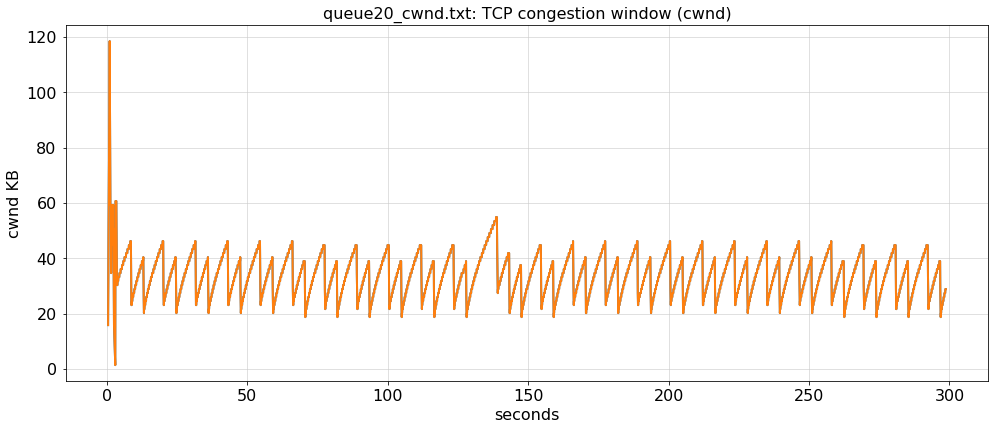

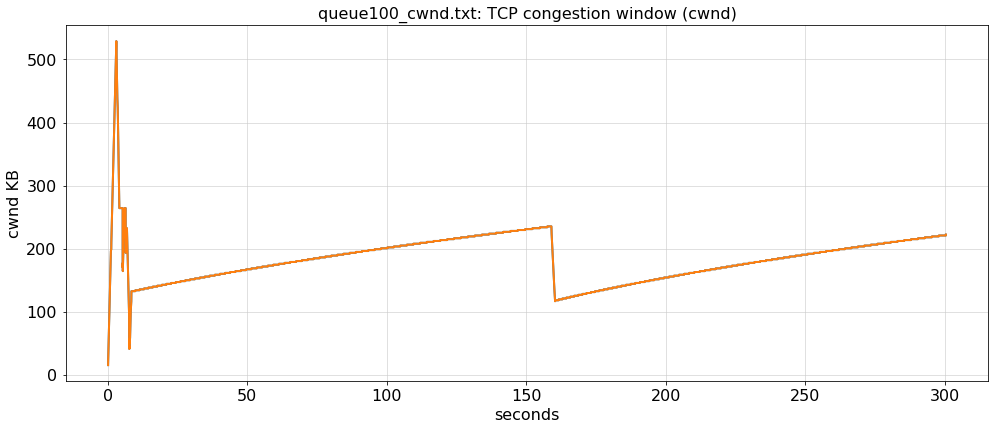

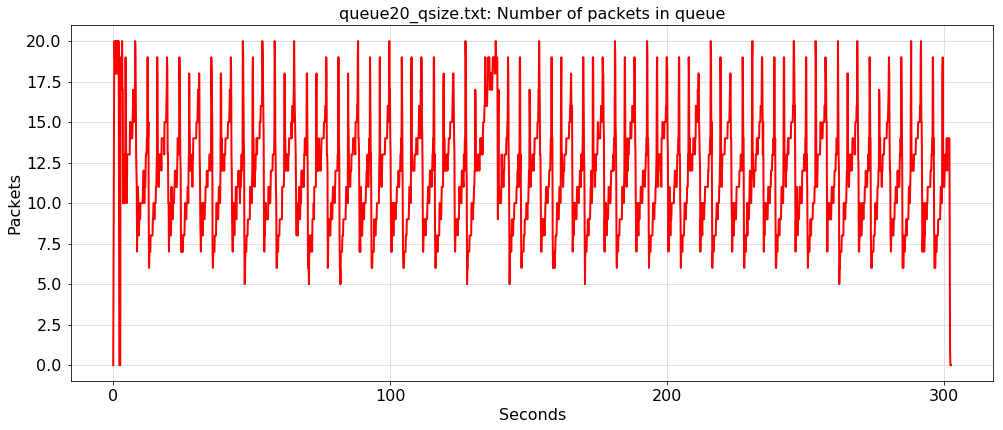

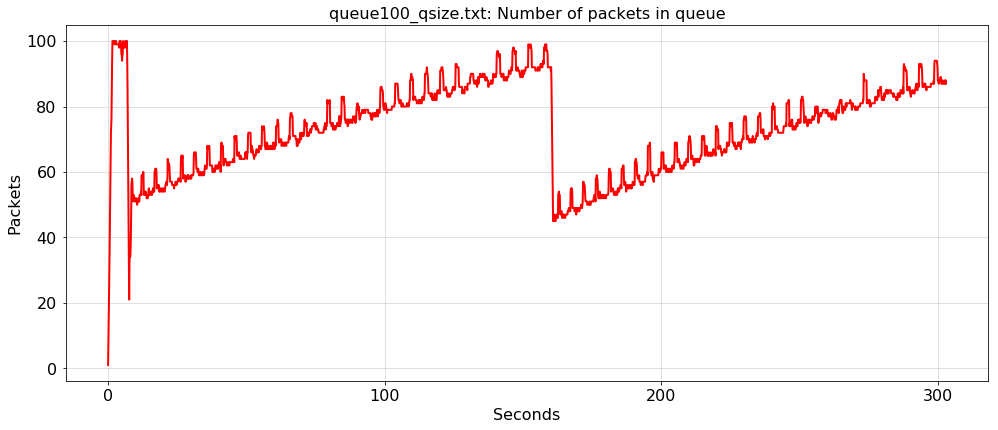

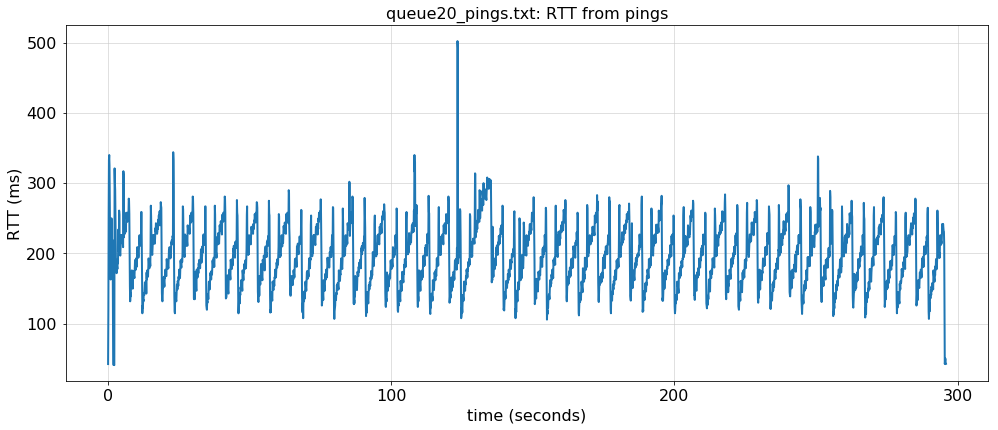

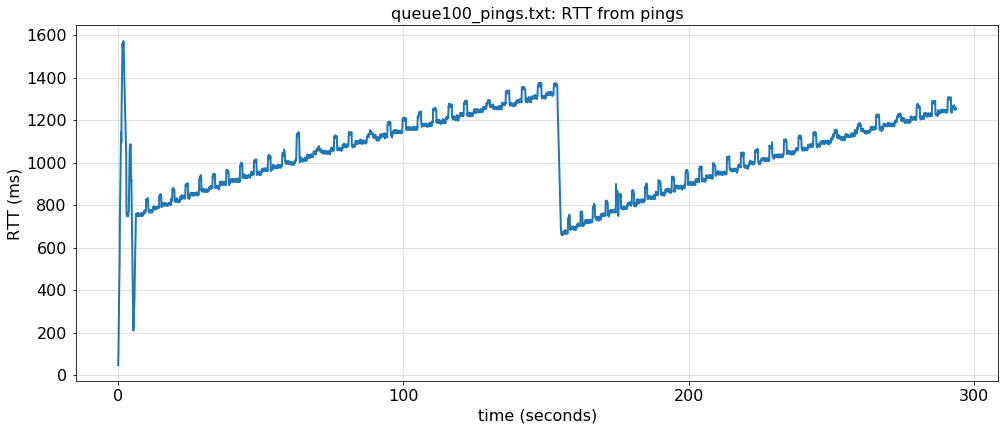

In [44]:
#TODO: Call plot_measurements() to plot your results
# Generate and plot the results for the experiments
experiment_name_list = ["queue20", "queue100"]

# Call the plot_measurements function to analyze and generate plots
plot_measurements(experiment_name_list, cwnd_histogram=False)


## Part C: Analysis

In this part of the assignment, you will answer some questions about TCP and bufferbloat using your simulations and the plots from the previous section.  This questions are intentionally open-ended and many have multiple correct answers.  There is no required answer length, but attempt to be both thorough and concise.  1-2 sentences is probably too short. More than 2-3 paragraphs is probably too long. 

Take some time first to think about the simulation you just performed. The simulation was set up like a home network with a home computer connected to a remote server through a router. The link from the router to the server had much lower bandwidth than the link from the home computer to the router. The independent variable in the simulation was the maximum length of the buffer of packets waiting to be sent from the router to the server. 

There were 3 sources of traffic:
1. A long-lasting TCP session (creating using iperf) sending a high volume of traffic from the home computer to the server.
2. Regularly spaced pings and ping replies to and from the home computer and the server
3. Regularly spaced attempts to download a website (using HTTP over TCP) from the home computer to the server.

As you (hopefully) discovered through the experiment, increasing the length of the packet buffer on the router significantly reduced performance by both ping RTT and HTTP download rate metrics. 

### Questions

#### Q1.
What computer networks other than a home network might have a configuration like the one you simulated?

#### A1.
*The Network similer to one which we have simulated is also found in Office Environments. In an offfice employee laptop or computers connect to a central router in the organization which then links to a remote data center, so basically if the connection between the router and the external network has less bandwidth than the internal office network so it may leads to congestion which in turns cause the delay in communication.*

#### Q2.
Write a symbolic equation to describe the relation between RTT and queue size. 

The symbolic equation should be generalized to any queue size. Basically, consider a snapshot of a system at one point of time, and use queue size and link delays parametrically to compute the RTT

An example (incorrect) symbolic equation: 
$$RTT = kq^2$$
where $k$ is a constant factor and $q$ is the number of packets in the queue. Your equation is not limited to $k$ and $q$. 

#### A2.
*So basically Total RTT can be expressed as the sum of Propagation time + Transmission time + Queuing time + Processing time 
Here it can be written as* 

$$RTT = \text{RTT}_{\text{base}} + \text{RTT}_{\text{queue}}
$$

*Also $RTT(queue)$ can be written as $\frac{qL}{B}$*

*$B$ is bandwidth, $q$ is number of packets in the queue, $L$ is the packet size, $S$ is speed, $D$ is Distance* 

Or it can be written as $$RTT = 2 \times \left( \frac{L}{R} + \frac{D}{S} \right) + \frac{qL}{B}$$


#### Q3.  
Describe in technical terms why increasing buffer size reduces performance (RTTs and webpage download times), causing the bufferbloat effect.  Be sure to explicitly reference the plots you generated and the relationship between TCP congestion control and buffer size. *This is the most important question and will be weighted correspondingly more.*

#### A3.
*So When the buffer size in a router is increased, it may leads to bufferbloat condition, it's a condition where excessive queuing delays will degrade the network performances. This is also clearly illustrated in the plots as well:*

$Effect$ $on$ $RTT$:

$Experiment 1$ :- *With a buffer size of 20 packets, the RTT fluctuates between 100 ms and 300 ms approx (as shown in the queue20 RTT vs Time plot), allowing for relatively low latency.*

$Experiment 2$ :- *When the buffer size is increased to 100 packets, RTT spikes up to 1500 ms (queue100 RTT vs Time plot) because packets spend significantly more time waiting in the queue before they were transmitted.*

$TCP$ $Congestion$ $Contro$l $Behavior$:

*So, in the case of 20 packet buffer, the TCP congestion window (cwnd) oscillates between 20 and 50 packets (queue20 cwnd vs time plot), It helps the sender to adjust their behavior to reduce congestion and improve network performance.
but With a 100-packet buffer, the congestion window grows excessively to over 500 packets (queue100 cwnd vs time plot) due to delayed acknowledgment signals. This delayed feedback leads to abrupt drops in the congestion window when the queue overflows, resulting in packet loss and retransmissions.*

$Impact$ $on$ $Webpage$ $Download$ $Times$:

*High RTT values (up to 1500 ms) with a 100-packet buffer cause extension in HTTP request-response delays, slowing down webpage downloads significantly. on the other hand, the 20-packet buffer keeps RTTs below 300 ms, ensuring faster round trips.
In technical terms, increasing buffer size introduces high queuing delays, leading to inefficient TCP congestion control and longer end-to-end latency, as observed in the RTT and cwnd trends.*


#### Q4. 
Re-describe the cause of the bufferbloat effect using a non-technical analogy to something other than computer networking.  It is important to be able to describe technical content such that a layperson can understand, and generating analogies often helps your own reasoning. 

#### A4.
*Basically this can be understand by simple analogy of grocery store,let's suppose a checkout line at a grocery store where customers (data packets) wait to pay for their items. The cashier can only process a certain number of customers per minute (bandwidth).If the waiting area is small (small buffer), any additional customers must either wait or come back later (packet loss). This setup keeps the line moving steadily and prevents overcrowding.*

*If the waiting area is large (large buffer), more shoppers can queue customers at the back have to wait much longer to reach the cashier (high latency), also new shoppers are joining the line, unaware of how long the wait time actually is.This makes the whole checkout process slower, just like what happens in a network when it experiencing the bufferbloat*

#### Q5. 
Is the bufferbloat effect specific to the type of network, traffic, and/or TCP congestion control algorithm we simulated, or is it a general phenomenon?

Are there any times when increasing router buffer size would improve performance? If so, give an example.  If not, explain why not. 

#### A5.
*The bufferbloat effect is a general issue which is not limited to specific networks, traffic types, or TCP congestion control algorithms. It happens whenever excessive buffering increases latency and delays feedback about the congestion. This can also be happen in any network like home networks, mobile networks, corporate systems etc.*

*Also, increasing buffer size can sometimes improve performance in cases where the network traffic is bursty but not continuous.This is common in live-streaming applications, here larger buffers can prevent packet loss and improve stability.* 

#### Q6.
Identify and describe a way to mitigate the bufferbloat problem without reducing buffer sizes.  

#### A6.
*There are some algorithms to address this bufferbloat problem like by using Active Queue Management (AQM) techniques like CoDel (Controlled Delay) or FQ-CoDel (Fair Queuing Controlled Delay). These methods actively regulate queue sizes by marking or dropping packets before the buffer fills up fully, which makes the TCP to adjust its congestion window early.*

*Another strategy is to implement Explicit Congestion Notification (ECN). ECN enables routers to mark packets which encounter congestion instead of discarding them, which helps to reduce retransmissions, enhances data throughput, and maintains low latency*

#####  ANTI-PLAGIARISM Statement

*I certify that this assignment/report is the result of my own independent work, based on my personal study and research. All sources, including books, articles, software, datasets, reports, and communications, have been properly acknowledged. This work has not been previously submitted for assessment in any other course unless specific permission was granted by the respective instructors.*

*I also acknowledge the use of AI tools, such as LLMs (e.g., ChatGPT), for assistance in refining this assignment, if used. I have ensured that their usage complies with the academic integrity policies of this course.
I pledge to uphold the principles of honesty, integrity, and responsibility at CSE@IITH, and understand my duty to report any violations of academic integrity by others if I become aware of them.*

*Name: Kshitij Shrivastava*

*Roll No: SM24MTECH14005*

*Date: 17-11-2024*

*Signature: KS*


## Submission 

**Remember to "Save and Checkpoint" (from the "File" menu above) before you leave the notebook or close your tab.**
